In [1]:
import random
from itertools import product

import dimod
import networkx as nx
import numpy as np
from dwave.system import LeapHybridSampler
from dwave.samplers import (
    TabuSampler,
    SimulatedAnnealingSampler,
    SteepestDescentSolver,
)
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from modules.utils import distance, output_image

In [2]:
def set_up_scenario(w, h, num_poi, num_cs):
    """Build scenario set up with specified parameters.

    Args:
        w (int): Width of grid
        h (int): Height of grid
        num_poi (int): Number of points of interest
        num_cs (int): Number of existing charging stations

    Returns:
        G (networkx graph): Grid graph of size w by h
        pois (list of tuples of ints): A fixed set of points of interest
        charging_stations (list of tuples of ints):
            Set of current charging locations
        potential_new_cs_nodes (list of tuples of ints):
            Potential new charging locations
    """

    G = nx.grid_2d_graph(w, h)
    nodes = list(G.nodes)

    # Identify a fixed set of points of interest
    pois = random.sample(nodes, k=num_poi)

    # Identify a fixed set of current charging locations
    charging_stations = random.sample(nodes, k=num_cs)

    # Identify potential new charging locations
    potential_new_cs_nodes = list(G.nodes() - set(charging_stations) -set(pois))

    avg_dist = np.mean(cdist(pois, charging_stations, "cityblock"))
    sigma = avg_dist / np.sqrt(2 * np.log(1000))

    return G, pois, charging_stations, potential_new_cs_nodes, sigma

In [21]:
def build_bqm(
    potential_new_cs_nodes,
    num_poi,
    pois,
    num_cs,
    charging_stations,
    num_new_cs,
    hyperparams=np.array([4, 3, 1.7, 10]),
):
    """Build bqm that models our problem scenario for the hybrid sampler.

    Args:
        potential_new_cs_nodes (list of tuples of ints):
            Potential new charging locations
        num_poi (int): Number of points of interest
        pois (list of tuples of ints): A fixed set of points of interest
        num_cs (int): Number of existing charging stations
        charging_stations (list of tuples of ints):
            Set of current charging locations
        num_new_cs (int): Number of new charging stations desired

    Returns:
        bqm_np (BinaryQuadraticModel): QUBO model for the input scenario
    """
    a, b, c, d = hyperparams

    # Tunable parameters
    alpha = len(potential_new_cs_nodes) * a  # 4
    beta = len(potential_new_cs_nodes) / b  # 3
    gamma = len(potential_new_cs_nodes) * c  # 1.7
    delta = len(potential_new_cs_nodes) ** d  # 3

    # Build BQM using adjVectors to find best new charging location s.t. min
    # distance to POIs and max distance to existing charging locations
    bqm = dimod.BinaryQuadraticModel(len(potential_new_cs_nodes), "BINARY")

    # Constraint 1: Min average distance to POIs
    if num_poi > 0:
        for i in range(len(potential_new_cs_nodes)):
            # Compute average distance to POIs from this node
            cand_loc = potential_new_cs_nodes[i]
            avg_dist = sum(distance(cand_loc, loc) for loc in pois) / num_poi
            bqm.linear[i] += avg_dist * np.log2(avg_dist) * alpha

    # Constraint 2: Max distance to existing chargers
    if num_cs > 0:
        for i in range(len(potential_new_cs_nodes)):
            # Compute average distance to POIs from this node
            cand_loc = potential_new_cs_nodes[i]
            avg_dist = (
                sum(distance(cand_loc, loc) for loc in charging_stations) / num_cs
            )
            bqm.linear[i] -= avg_dist * beta

    # Constraint 3: Max distance to other new charging locations
    if num_new_cs > 1:
        for i in range(len(potential_new_cs_nodes)):
            for j in range(i + 1, len(potential_new_cs_nodes)):
                ai = potential_new_cs_nodes[i]
                aj = potential_new_cs_nodes[j]
                dist = -distance(ai, aj)
                bqm.add_interaction(i, j, dist * gamma)

    # Constraint 4: Choose exactly num_new_cs new charging locations
    bqm.update(
        dimod.generators.combinations(bqm.variables, num_new_cs, strength=delta)
    )

    return bqm

In [22]:
def run_bqm_and_collect_solutions(
    bqm, sampler, potential_new_cs_nodes, n_shots=1, **kwargs
):
    """Solve the bqm with the provided sampler to find new charger locations.

    Args:
        bqm (BinaryQuadraticModel): The QUBO model for the problem instance
        sampler: Sampler or solver to be used
        potential_new_cs_nodes (list of tuples of ints):
            Potential new charging locations
        **kwargs: Sampler-specific parameters to be used

    Returns:
        new_charging_nodes (list of tuples of ints):
            Locations of new charging stations
    """

    sampleset = sampler.sample(
        bqm, num_reads=n_shots, **kwargs
    )
    ss = sampleset.first.sample
    new_charging_nodes = [potential_new_cs_nodes[k] for k, v in ss.items() if v == 1]
    return sampleset, new_charging_nodes

In [23]:
def influence_matrix(x, y, sigma):
    dist_matrix = cdist(x, y, "cityblock")
    return np.exp(-(dist_matrix**2) / (2 * sigma**2))


def score_sampleset(
    sampleset,
    potential_new_cs_nodes,
    pois,
    charging_stations,
    sigma,
    new_charging_nodes=None,
):
    """
    Score the sampleset based on the distance to POIs and existing charging stations.
    """
    n_samples = len(sampleset)

    if new_charging_nodes is None:
        new_charging_nodes = [
            [potential_new_cs_nodes[k] for k, v in sample.items() if v == 1]
            for sample in sampleset
        ]

    total_influence = np.zeros(n_samples)
    for i, new_cs in enumerate(new_charging_nodes):
        cs = charging_stations + new_cs
        pois_influence_matrix = influence_matrix(pois, cs, sigma)
        cs_influence_matrix = influence_matrix(cs, cs, sigma)
        total_influence[i] = np.sum(pois_influence_matrix) / np.sum(
            cs_influence_matrix
        )
    score = np.mean(total_influence) + np.var(total_influence)
    return score

    # min_dist = min_dist.sum(axis=1)
    # score = min_dist.mean() + min_dist.var()
    # return score

In [46]:
def search_hyperparams(
    init_guess,
    potential_new_cs_nodes,
    num_poi,
    pois,
    num_cs,
    charging_stations,
    num_new_cs,
    sigma,
):
    init_guess += 100
    def objective(hyperparams):
        bqm = build_bqm(
            potential_new_cs_nodes,
            num_poi,
            pois,
            num_cs,
            charging_stations,
            num_new_cs,
            hyperparams=hyperparams - 100,
        )
        sampleset, _ = run_bqm_and_collect_solutions(
            bqm, SimulatedAnnealingSampler(), potential_new_cs_nodes, num_shots=1
        )
        score = score_sampleset(
            sampleset, potential_new_cs_nodes, pois, charging_stations, sigma
        )
        return -score

    best_result = minimize(objective, init_guess, method="Nelder-Mead", bounds=[(101, 1000)] * 4)
    best_params = best_result.x - 100
    return best_params

In [47]:
WIDTH = 30
HEIGHT = 30
POI = 10
CHARGERS = 3
NEW_CHARGERS = 4

"""WIDTH = 30
HEIGHT = 30
POI = 10
CHARGERS = 3
NEW_CHARGERS = 3"""

sampler = SimulatedAnnealingSampler()

G, pois, charging_stations, potential_new_cs_nodes, sigma = set_up_scenario(
    WIDTH, HEIGHT, POI, CHARGERS
)

hyperparams = np.array([4, 3, 1.7, 3])
hyper = np.array([3.46171877, 1.85156246, 2.9017289 , 5.02177708])

In [48]:
hyper = search_hyperparams(
    hyperparams,
    potential_new_cs_nodes,
    POI,
    pois,
    CHARGERS,
    charging_stations,
    NEW_CHARGERS,
    sigma,
)

In [49]:
hyper

array([3.88053908, 1.73187536, 5.01828836, 8.4677762 ])


Score:  0.7279619033591443


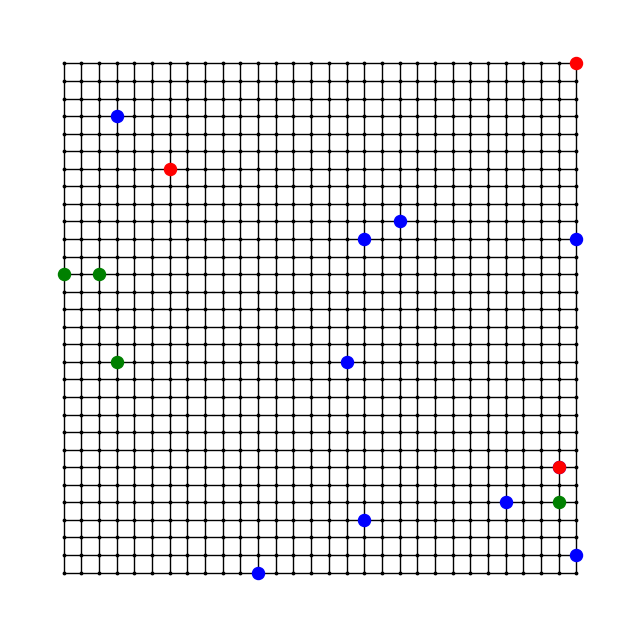

In [50]:
# Build BQM
bqm = build_bqm(
    potential_new_cs_nodes,
    POI,
    pois,
    CHARGERS,
    charging_stations,
    NEW_CHARGERS,
    hyper #hyperparams,
)

sampleset, new_charging_nodes = run_bqm_and_collect_solutions(
    bqm, sampler, potential_new_cs_nodes, n_shots=10
)

# Calculate score
score = score_sampleset(sampleset, potential_new_cs_nodes, pois, charging_stations, sigma)

# Create scenario output image
print("\nScore: ", score)
output_image(G, pois, charging_stations, new_charging_nodes)